In [452]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import os
import pickle
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance
from scipy import stats
import statsmodels.api as sm

In [2]:
if os.path.split(os.getcwd())[-1] == 'notebooks': os.chdir(os.path.split(os.getcwd())[-2])
print(os.getcwd())

/home/fitzaudoen/apps/gas-sensor-analytics-demo


In [3]:
sns.set()
sns.set_context('talk')

# Set up data

In [4]:
df = pd.read_pickle('data/processed/train_data.pkl')

In [5]:
data = df.values
batch_id = data[:,0] # unused
y = data[:,2] 
X = data[:,3:] 
cols = df.columns.values

## Load standard scaler and encoder

In [6]:
scaler = pickle.load(
    open('models/preprocessing/scaler.pkl','rb')
)
pca = pickle.load(
    open('models/preprocessing/pca.pkl','rb')
)

In [7]:
X = scaler.transform(X)
X_pca = pca.transform(X)

In [247]:
encoder = scaler = pickle.load(
    open('models/preprocessing/encoder.pkl','rb')
)

## Add encoded categorical features to X array

In [248]:
X_cat = encoder.transform(data[:,1:2])

In [10]:
X = np.concatenate((X,X_cat),axis=1)
X_pca = np.concatenate((X_pca,X_cat),axis=1)

In [11]:
cv_df = pd.read_pickle('data/processed/cv_data.pkl')

In [12]:
data_cv = cv_df.values
batch_id_cv = data_cv[:,0]
y_cv = data_cv[:,2]
X_cv = scaler.transform(data_cv[:,3:])
X_cv_pca = pca.transform(X_cv)

In [13]:
X_cat_cv = encoder.fit_transform(data_cv[:,1:2])
X_cv = np.concatenate((X_cv,X_cat_cv),axis=1)
X_cv_pca = np.concatenate((X_cv_pca,X_cat_cv),axis=1)

In [54]:
feature_labels = np.concatenate((cols[3:].reshape(1,129),encoder.categories_),axis=1)

# Helper Functions

# Regression Models 

### Helper Function

In [249]:
# Take a regressor as input and compare how score vs number of samples
def gen_learning_curve(regressor,X,y,X_cv,y_cv):
    n_arr = list(range(50,250,25)) + list(range(250,len(X),500))
    scores_learn = []
    scores_learn_cv = []
    for n in n_arr:
        reg = regressor.fit(X[0:n,:], y[0:n])
        scores_learn.append(reg.score(X[0:n,:],y[0:n]))
        scores_learn_cv.append(reg.score(X_cv,y_cv))
    return n_arr, scores_learn, scores_learn_cv



## Linear
Poor fit relative to other models
- R2 intially looked good, but the residuals show a large number of outliers


### Initial Parameters

In [292]:
reg_lin = LinearRegression()

In [293]:
reg_lin.fit(X,y)

LinearRegression()

In [295]:
print('Linear score training:',reg_lin.score(X,y))
print('Linear score CV:',reg_lin.score(X_cv,y_cv))

Linear score training: 0.9501554048654408
Linear score CV: 0.9381306649357636


### Learning Curve

In [17]:
n_arr_lr, scores_learn_lr, scores_learn_lr_cv = gen_learning_curve(LinearRegression(), X, y, X_cv, y_cv)

(0.0, 1.0)

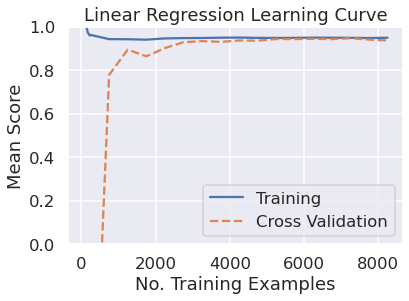

In [18]:
fig, ax = plt.subplots()
ax.plot(n_arr_lr,scores_learn_lr,label='Training')
ax.plot(n_arr_lr,scores_learn_lr_cv,'--',label='Cross Validation')
ax.set_title('Linear Regression Learning Curve')
ax.set_xlabel('No. Training Examples')
ax.set_ylabel('Mean Score')
ax.legend()
ax.set_ylim(0,1)

### Goodness of Fit

In [297]:
y_pred_lin = reg_lin.predict(X)
y_pred_lin_cv = reg_lin.predict(X_cv)

In [298]:
print('Sampels w/ error > 10%:',len(y_pred_lin_cv[abs(y_cv-y_pred_lin_cv)/y_cv > .1])/len(y_cv))
print('Sampels w/ error > 100%:',len(y_pred_lin_cv[abs(y_cv-y_pred_lin_cv)/y_cv > 1])/len(y_cv))
error_per_lin = abs(y_cv-y_pred_lin_cv)/y_cv

Sampels w/ error > 10%: 0.5880661394680087
Sampels w/ error > 100%: 0.09022286125089864


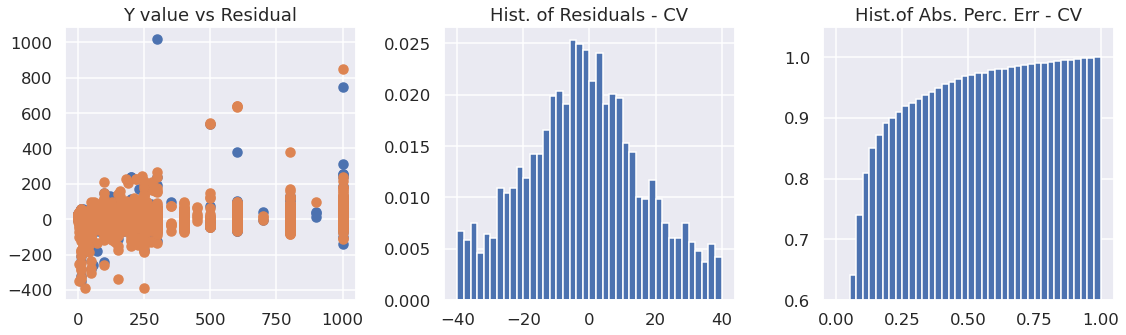

In [299]:
fig, ax = plt.subplots(1,3,figsize=(16,5))

ax[0].scatter(y_cv,y_cv-y_pred_lin_cv, label='Cross Validation')
ax[0].scatter(y,y-y_pred_lin, label='Training')
ax[0].set_title('Y value vs Residual')

ax[1].hist(y_cv-y_pred_lin_cv, density=True, range=(-40,40), bins=40)
ax[1].set_title('Hist. of Residuals - CV')

ax[2].hist(error_per,range=(0,1),cumulative=True, density=True, bins=40)
ax[2].set_ylim(.6)
ax[2].set_title('Hist.of Abs. Perc. Err - CV')

plt.tight_layout()

## Support Vector Regression
- Good example of R2 not showing the whole picture
- Worse R2 than linear model, but residuals are better distributed and more of the data is within 10% error and within 100% error

### Change parms manually

In [310]:
reg_svr = SVR(C=10000)
reg_svr.fit(X,y)
reg_svr.score(X,y)

0.9307233380371575

In [311]:
reg_svr.score(X_cv,y_cv)

0.9207155757741152

### Parameter Optimization

In [21]:
C_arr_svr = [10,100,1000,5000,10000]
score_arr_svr = []
score_arr_svr_cv = []
for C in C_arr_svr:
    clf = SVR(C=C)
    clf = clf.fit(X, y)
    score_arr_svr.append(clf.score(X,y))
    score_arr_svr_cv.append(clf.score(X_cv,y_cv))

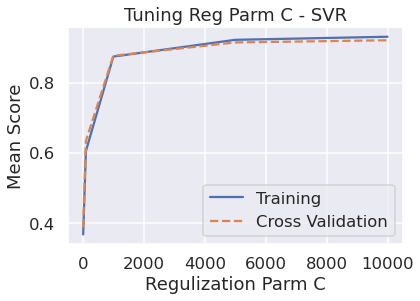

In [22]:
fig, ax = plt.subplots()
ax.plot(C_arr_svr,score_arr_svr, label='Training')
ax.plot(C_arr_svr,score_arr_svr_cv, '--',label='Cross Validation')
ax.set_xlabel('Regulization Parm C')
ax.set_ylabel('Mean Score')
ax.set_title('Tuning Reg Parm C - SVR')
ax.legend()

### Goodness of fit

In [312]:
y_pred_svr = reg_svr.predict(X)
y_pred_svr_cv = reg_svr.predict(X_cv)

In [389]:
print('Samples w/ error > 10%:',len(y_pred_svr_cv[abs(y_cv-y_pred_svr_cv)/y_cv > .1])/len(y_cv))
print('Samples w/ error > 100%:',len(y_pred_svr_cv[abs(y_cv-y_pred_svr_cv)/y_cv > 1])/len(y_cv))
error_per_svr = abs(y_cv-y_pred_svr_cv)/y_cv

Samples w/ error > 10%: 0.5273184759166067
Samples w/ error > 100%: 0.06901509705248023


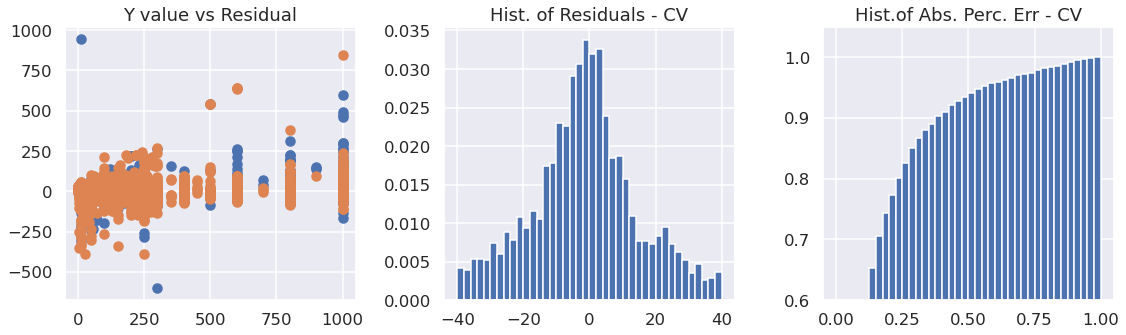

In [314]:
fig, ax = plt.subplots(1,3,figsize=(16,5))

ax[0].scatter(y_cv,y_cv-y_pred_svr_cv, label='Cross Validation')
ax[0].scatter(y,y-y_pred_lin, label='Training')
ax[0].set_title('Y value vs Residual')

ax[1].hist(y_cv-y_pred_svr_cv, density=True, range=(-40,40), bins=40)
ax[1].set_title('Hist. of Residuals - CV')

ax[2].hist(error_per_svr,range=(0,1),cumulative=True, density=True, bins=40)
ax[2].set_ylim(.6)
ax[2].set_title('Hist.of Abs. Perc. Err - CV')

plt.tight_layout()

## Random Forest Regression
- Best performing algorithm
- Tightest distribution of residuals, and most data < 10% and < 100%

### Tuning

In [415]:
reg_rf = RandomForestRegressor(n_estimators=200, random_state=10, max_features ='log2')

In [416]:
reg_rf.fit(X,y)
print(reg_rf.score(X,y))
print(reg_rf.score(X_cv,y_cv))

0.9967794889034102
0.9768305357088255


#### N-estimators 

In [395]:
n_arr_rf= [50,100,150,200,250]
score_arr_rf = []
score_arr_rf_cv = []
for n in n_arr_rf:
    reg = RandomForestRegressor(n_estimators=n)
    reg = reg.fit(X, y)
    score_arr_rf.append(reg.score(X,y))
    score_arr_rf_cv.append(reg.score(X_cv,y_cv))

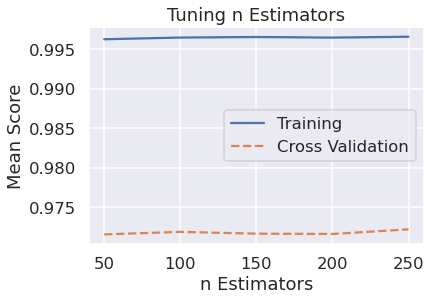

In [396]:
fig, ax = plt.subplots()
ax.plot(n_arr_rf,score_arr_rf, label='Training')
ax.plot(n_arr_rf,score_arr_rf_cv, '--',label='Cross Validation')
ax.set_xlabel('n Estimators')
ax.set_ylabel('Mean Score')
ax.set_title('Tuning n Estimators')
ax.legend()

#### Max Features

In [397]:
mf_arr_rf= ['auto','sqrt','log2']
mf_score_arr_rf = []
mf_score_arr_rf_cv = []
for mf in mf_arr_rf:
    reg = RandomForestRegressor(n_estimators=200, max_features=mf)
    reg = reg.fit(X, y)
    mf_score_arr_rf.append(reg.score(X,y))
    mf_score_arr_rf_cv.append(reg.score(X_cv,y_cv))

Text(0.5, 0, 'Max Features Method')

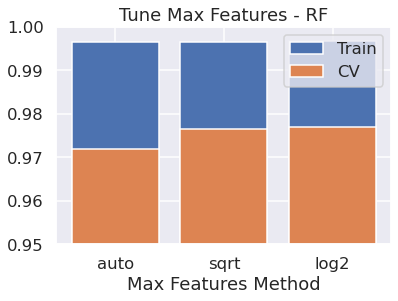

In [414]:
plt.bar(x=[1,2,3], height=mf_score_arr_rf, tick_label=mf_arr_rf, label='Train')
plt.bar(x=[1,2,3], height=mf_score_arr_rf_cv, tick_label=mf_arr_rf, label='CV')
plt.ylim(.95,1)
plt.legend()
plt.title('Tune Max Features - RF')
plt.xlabel('Max Features Method')

In [402]:
y

array([10.0, 10.0, 10.0, ..., 150.0, 225.0, 50.0], dtype=object)

### Learning Curve

In [417]:
n_arr_rf, scores_learn_rf, scores_learn_lr_rf = gen_learning_curve(
    RandomForestRegressor(
    n_estimators=200, random_state=10, max_features ='log2'
    ),
    X, y, X_cv, y_cv
)

(0.4, 1.0)

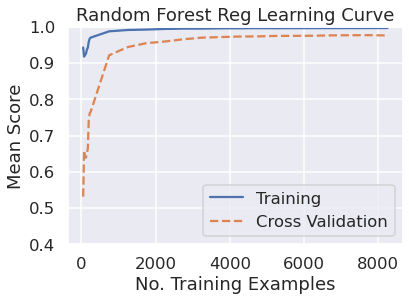

In [418]:
fig, ax = plt.subplots()
ax.plot(n_arr_rf,scores_learn_rf, label='Training')
ax.plot(n_arr_rf,scores_learn_lr_rf,'--', label='Cross Validation')
ax.set_title('Random Forest Reg Learning Curve')
ax.set_xlabel('No. Training Examples')
ax.set_ylabel('Mean Score')
ax.legend()
ax.set_ylim(.4,1)

### Goodness of fit

In [419]:
y_pred_rf = reg_rf.predict(X)
y_pred_rf_cv = reg_rf.predict(X_cv)

In [422]:
print('Sampels w/ error > 10%:',len(y_pred_rf_cv[abs(y_cv-y_pred_rf_cv)/y_cv > .1])/len(y_cv))
print('Sampels w/ error > 100%:',len(y_pred_rf_cv[abs(y_cv-y_pred_rf_cv)/y_cv > 1])/len(y_cv))
error_per_rf = abs(y_cv-y_pred_svr_cv)/y_cv

Sampels w/ error > 10%: 0.21315600287562905
Sampels w/ error > 100%: 0.021567217828900073


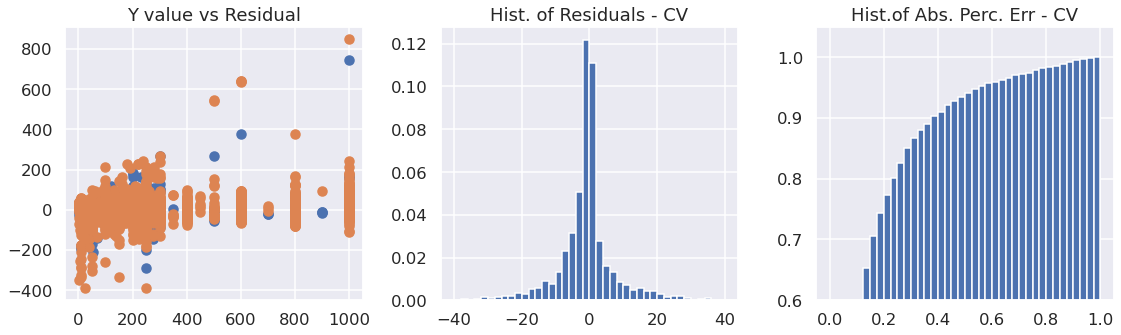

In [423]:
fig, ax = plt.subplots(1,3,figsize=(16,5))

ax[0].scatter(y_cv,y_cv-y_pred_rf_cv, label='Cross Validation')
ax[0].scatter(y,y-y_pred_lin, label='Training')
ax[0].set_title('Y value vs Residual')

ax[1].hist(y_cv-y_pred_rf_cv, density=True, range=(-40,40), bins=40)
ax[1].set_title('Hist. of Residuals - CV')

ax[2].hist(error_per_rf,range=(0,1),cumulative=True, density=True, bins=40)
ax[2].set_ylim(.6)
ax[2].set_title('Hist.of Abs. Perc. Err - CV')

plt.tight_layout()

### Feature Importance

#### Tree based feature importance

In [424]:
importance_rf = reg_rf.feature_importances_
importance_rf = importance_rf.reshape(1,len(importance_rf))

In [425]:
sorted_idx_rf = np.argsort(importance_rf)
sorted_idx_rf = sorted_idx_rf[0]#[::-1]

In [426]:
pos = np.arange(feature_labels.shape[1])

#### Permutation Based Feature Importance

In [427]:
r_rf = permutation_importance(reg_rf, X_cv, y_cv,
                           n_repeats=10, random_state=0)

In [428]:
perm_import_rf = r_rf.importances_mean

In [429]:
perm_idx_rf = np.argsort(perm_import_rf)#[::-1]

#### Plot Comparison

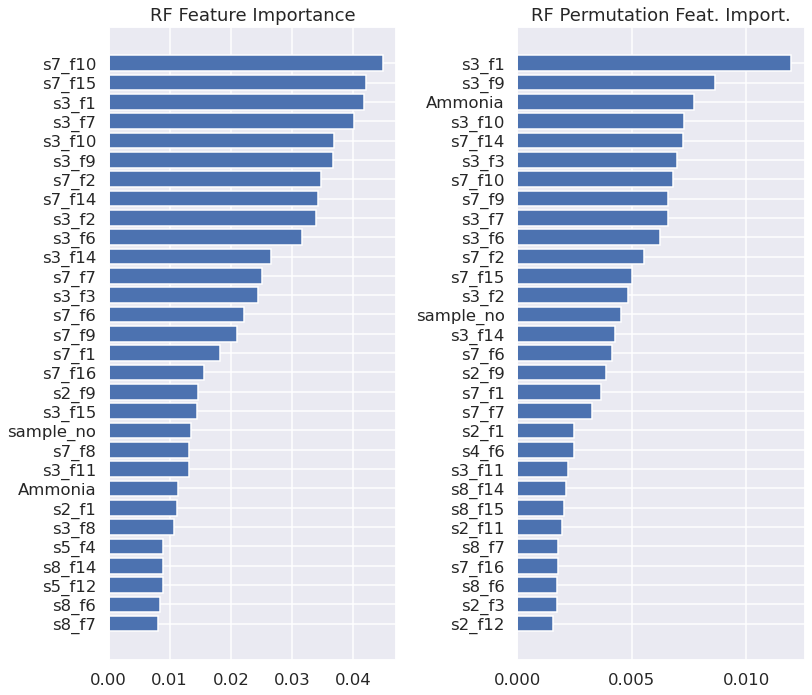

In [432]:
top_features = 30
fig, ax = plt.subplots(1,2,figsize=(12,10))
ax[0].barh(pos[-top_features:],importance_rf[0,sorted_idx_rf[-top_features:]])
ax[0].set_yticks(pos[-top_features:])
ax[0].set_yticklabels(feature_labels[0,sorted_idx_rf[-top_features:]])
ax[0].set_title('RF Feature Importance')

ax[1].barh(pos[-top_features:],perm_import_rf[perm_idx_rf[-top_features:]])
ax[1].set_yticks(pos[-top_features:])
ax[1].set_yticklabels(feature_labels[0,perm_idx_rf[-top_features:]])
ax[1].set_title('RF Permutation Feat. Import.')

plt.tight_layout()

# GradientBoosting Regression

## Tuning

### Check some parameters manually

In [16]:
reg_gbr = GradientBoostingRegressor(loss='lad',max_depth=50,n_estimators=125,learning_rate=.15)

In [17]:
reg_gbr.fit(X,y)

GradientBoostingRegressor(learning_rate=0.15, loss='lad', max_depth=50,
                          n_estimators=125)

In [18]:
print(reg_gbr.score(X,y))
print(reg_gbr.score(X_cv,y_cv))

0.9987301862165435
0.9703034993538323


In [20]:
len(y_pred_gbr[abs(y-y_pred_gbr)/y > .05])/len(y)

0.01737359213994728

### Tune N Estimators

In [21]:
n_arr_gbr = [10,25,50,75,100,125]
score_arr_gbr = []
score_arr_gbr_cv = []
for n in n_arr_gbr:
    reg = GradientBoostingRegressor(loss='lad',max_depth=50,n_estimators=n)
    reg = reg.fit(X, y)
    score_arr_gbr.append(reg.score(X,y))
    score_arr_gbr_cv.append(reg.score(X_cv,y_cv))

(0.95, 1.0319233888113688)

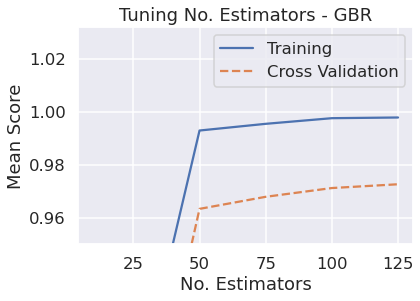

In [23]:
fig, ax = plt.subplots()
ax.plot(n_arr_gbr,score_arr_gbr, label='Training')
ax.plot(n_arr_gbr,score_arr_gbr_cv, '--',label='Cross Validation')
ax.set_xlabel('No. Estimators')
ax.set_ylabel('Mean Score')
ax.set_title('Tuning No. Estimators - GBR')
ax.legend()
ax.set_ylim(.95)


### Tune Learning Rate

In [24]:
lr_arr_gbr = [.01,.05,.1,.15,.2]
lr_score_arr_gbr = []
lr_score_arr_gbr_cv = []
for lr in lr_arr_gbr:
    reg = GradientBoostingRegressor(loss='lad',max_depth=50,n_estimators=125, learning_rate=lr)
    reg = reg.fit(X, y)
    lr_score_arr_gbr.append(reg.score(X,y))
    lr_score_arr_gbr_cv.append(reg.score(X_cv,y_cv))

(0.95, 1.0279789289503793)

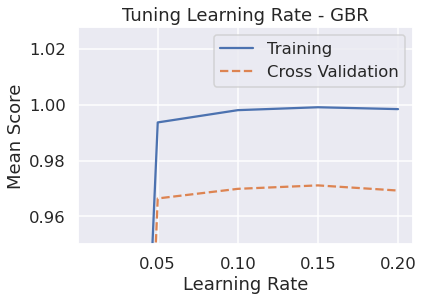

In [25]:
fig, ax = plt.subplots()
ax.plot(lr_arr_gbr,lr_score_arr_gbr, label='Training')
ax.plot(lr_arr_gbr,lr_score_arr_gbr_cv, '--',label='Cross Validation')
ax.set_xlabel('Learning Rate')
ax.set_ylabel('Mean Score')
ax.set_title('Tuning Learning Rate - GBR')
ax.legend()
ax.set_ylim(.95,)

### Learning Curve

In [28]:
n_arr_gbr, scores_learn_gbr, scores_learn_lr_gbr = gen_learning_curve(
     GradientBoostingRegressor(loss='lad',max_depth=50,n_estimators=125,learning_rate=.15),
     X, y, X_cv, y_cv
)

(0.4, 1.0)

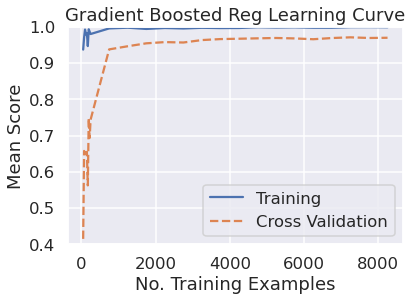

In [29]:
fig, ax = plt.subplots()
ax.plot(n_arr_gbr,scores_learn_gbr, label='Training')
ax.plot(n_arr_gbr,scores_learn_lr_gbr,'--', label='Cross Validation')
ax.set_title('Gradient Boosted Reg Learning Curve')
ax.set_xlabel('No. Training Examples')
ax.set_ylabel('Mean Score')
ax.legend()
ax.set_ylim(.4,1)

### Goodness of Fit

In [273]:
y_pred_gbr = reg_gbr.predict(X)
y_pred_gbr_cv = reg_gbr.predict(X_cv)

In [291]:
print('Sampels w/ error > 10%:',len(y_pred_gbr_cv[abs(y_cv-y_pred_gbr_cv)/y_cv > .1])/len(y_cv))
print('Sampels w/ error > 100%:',len(y_pred_gbr_cv[abs(y_cv-y_pred_gbr_cv)/y_cv > 1])/len(y_cv))
error_per_gbr = abs(y_cv-y_pred_gbr_cv)/y_cv

Sampels w/ error > 10%: 0.2670740474478792
Sampels w/ error > 100%: 0.02695902228612509


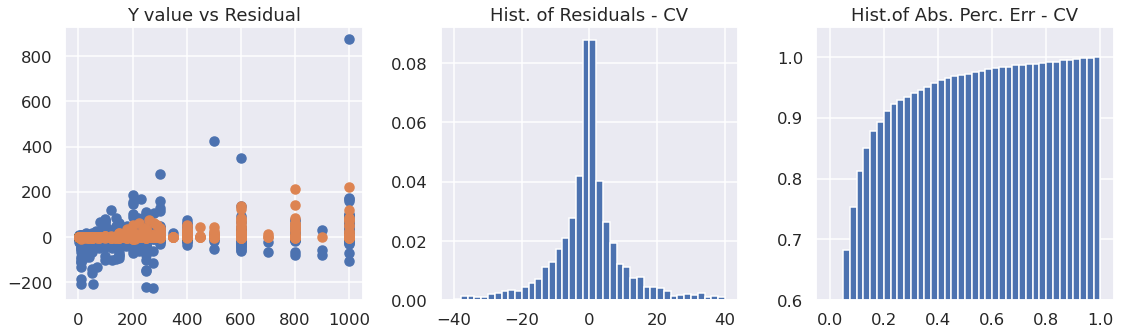

In [272]:
fig, ax = plt.subplots(1,3,figsize=(16,5))

ax[0].scatter(y_cv,y_cv-y_pred_gbr_cv, label='Cross Validation')
ax[0].scatter(y,y-y_pred_gbr, label='Training')
ax[0].set_title('Y value vs Residual')

ax[1].hist(y_cv-y_pred_gbr_cv, density=True, range=(-40,40), bins=40)
ax[1].set_title('Hist. of Residuals - CV')

ax[2].hist(error_per,range=(0,1),cumulative=True, density=True, bins=40)
ax[2].set_ylim(.6)
ax[2].set_title('Hist.of Abs. Perc. Err - CV')

plt.tight_layout()

### Feature Importance

#### Tree based feature importance

In [186]:
importance_gbr = reg_gbr.feature_importances_
importance_gbr = importance_gbr.reshape(1,len(importance_gbr))

In [187]:
sorted_idx = np.argsort(importance_gbr)
sorted_idx = sorted_idx[0]#[::-1]

In [188]:
pos = np.arange(feature_labels.shape[1])

#### Permutation Based Feature Importance

In [152]:
r_gbr = permutation_importance(reg_gbr, X_cv, y_cv,
                           n_repeats=10, random_state=0)

In [209]:
perm_import_gbr = r_gbr.importances_mean

In [210]:
perm_idx_gbr = np.argsort(perm_import_gbr)#[::-1]

#### Plot Comparison

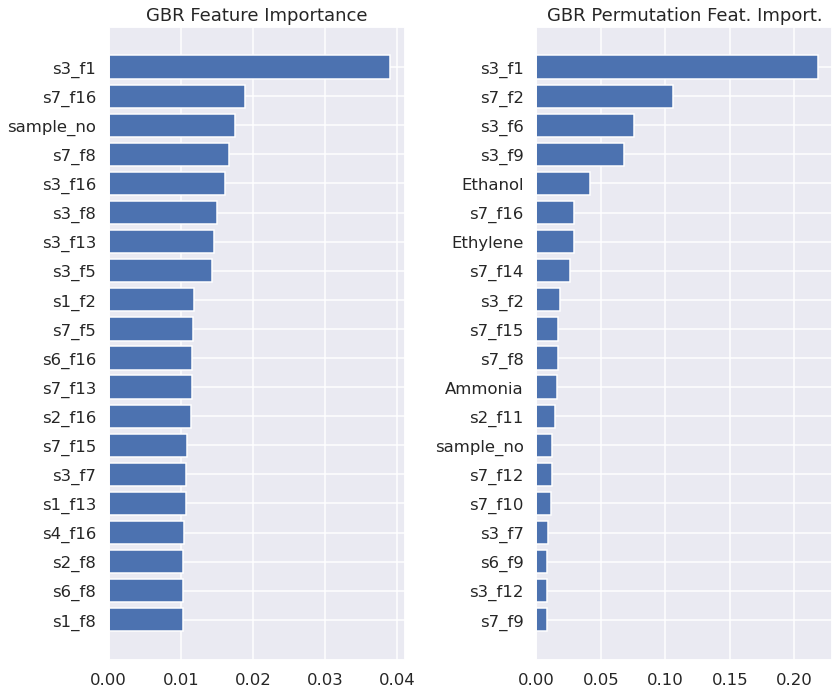

In [217]:
top_features = 20
fig, ax = plt.subplots(1,2,figsize=(12,10))
ax[0].barh(pos[-top_features:],importance_gbr[0,sorted_idx[-top_features:]])
ax[0].set_yticks(pos[-top_features:])
ax[0].set_yticklabels(feature_labels[0,sorted_idx[-top_features:]])
ax[0].set_title('GBR Feature Importance')

ax[1].barh(pos[-top_features:],perm_import_gbr[perm_idx_gbr[-top_features:]])
ax[1].set_yticks(pos[-top_features:])
ax[1].set_yticklabels(feature_labels[0,perm_idx_gbr[-top_features:]])
ax[1].set_title('GBR Permutation Feat. Import.')

plt.tight_layout()

## Neural Network

### Tuning

Check manual parameters

In [30]:
reg_mlp = MLPRegressor(max_iter=1000, hidden_layer_sizes=tuple(4*[136]),
                       alpha=0.01, random_state=10, learning_rate_init=.007)
reg_mlp.fit(X,y)

MLPRegressor(alpha=0.01, hidden_layer_sizes=(136, 136, 136, 136),
             learning_rate_init=0.007, max_iter=1000, random_state=10)

In [31]:
print('score training:',reg_mlp.score(X,y))
print('score cv:',reg_mlp.score(X_cv,y_cv))

score training: 0.9895060315738577
score cv: 0.9827903972623218


### Parameter tuning

#### No. Layers

In [33]:
n_arr_nn = [1,2,3,4,5,6]
score_arr_nn = []
score_arr_nn_cv = []
for n in n_arr_nn:
    reg = MLPRegressor(max_iter=1000,hidden_layer_sizes=tuple(n*[136]),alpha=0.00001)
    reg = reg.fit(X, y)
    score_arr_nn.append(reg.score(X,y))
    score_arr_nn_cv.append(reg.score(X_cv,y_cv))

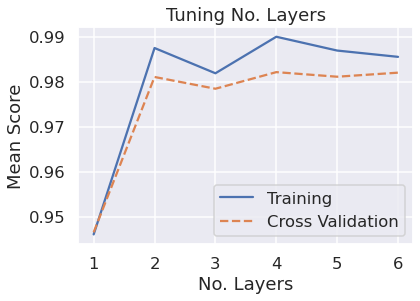

In [34]:
fig, ax = plt.subplots()
ax.plot(n_arr_nn,score_arr_nn, label='Training')
ax.plot(n_arr_nn,score_arr_nn_cv, '--',label='Cross Validation')
ax.set_xlabel('No. Layers')
ax.set_ylabel('Mean Score')
ax.set_title('Tuning No. Layers')
ax.legend()

#### Regularization

In [35]:
lr_arr_nn = [.001,.005,.0075,.01,.0125]
lr_score_arr_nn = []
lr_score_arr_nn_cv = []
for lr in lr_arr_nn:
    reg = MLPRegressor(max_iter=1000,hidden_layer_sizes=tuple(4*[136]),alpha=0.00001, learning_rate_init=lr, random_state=10)
    reg = reg.fit(X, y)
    lr_score_arr_nn.append(reg.score(X,y))
    lr_score_arr_nn_cv.append(reg.score(X_cv,y_cv))

(0.95, 1.0)

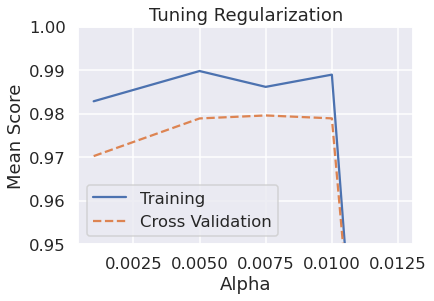

In [131]:
fig, ax = plt.subplots()
ax.plot(lr_arr_nn,lr_score_arr_nn, label='Training')
ax.plot(lr_arr_nn,lr_score_arr_nn_cv, '--',label='Cross Validation')
ax.set_xlabel('Alpha')
ax.set_ylabel('Mean Score')
ax.set_title('Tuning Regularization')
ax.legend()
ax.set_ylim(.95,1)

#### Learning Rate

In [37]:
a_arr_nn = [.01,.001,.0001,.00001]
a_score_arr_nn = []
a_score_arr_nn_cv = []
for a in a_arr_nn:
    reg = MLPRegressor(max_iter=1000,hidden_layer_sizes=tuple(4*[136]),alpha=a, learning_rate_init=.007, random_state=10)
    reg = reg.fit(X, y)
    a_score_arr_nn.append(reg.score(X,y))
    a_score_arr_nn_cv.append(reg.score(X_cv,y_cv))

(0.95, 1.0)

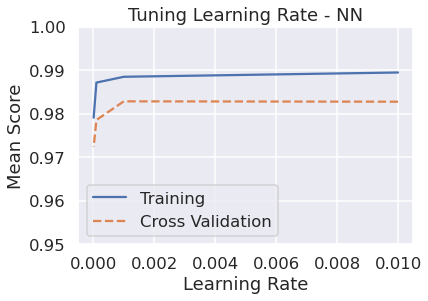

In [38]:
fig, ax = plt.subplots()
ax.plot(a_arr_nn,a_score_arr_nn, label='Training')
ax.plot(a_arr_nn,a_score_arr_nn_cv, '--',label='Cross Validation')
ax.set_xlabel('Learning Rate')
ax.set_ylabel('Mean Score')
ax.set_title('Tuning Learning Rate - NN')
ax.legend()
ax.set_ylim(.95,1)

### Goodness of fit

In [284]:
y_pred_nn_cv = reg_mlp.predict(X_cv)
y_pred_nn = reg_mlp.predict(X)

In [289]:
print('Sampels w/ error > 10%:',len(y_pred_nn_cv[abs(y_cv-y_pred_nn_cv)/y_cv > .1])/len(y_cv))
print('Sampels w/ error > 100%:',len(y_pred_nn_cv[abs(y_cv-y_pred_nn_cv)/y_cv > 1])/len(y_cv))
error_per_nn = abs(y_cv-y_pred_nn_cv)/y_cv

Sampels w/ error > 10%: 0.28720345075485265
Sampels w/ error > 100%: 0.038102084831056794


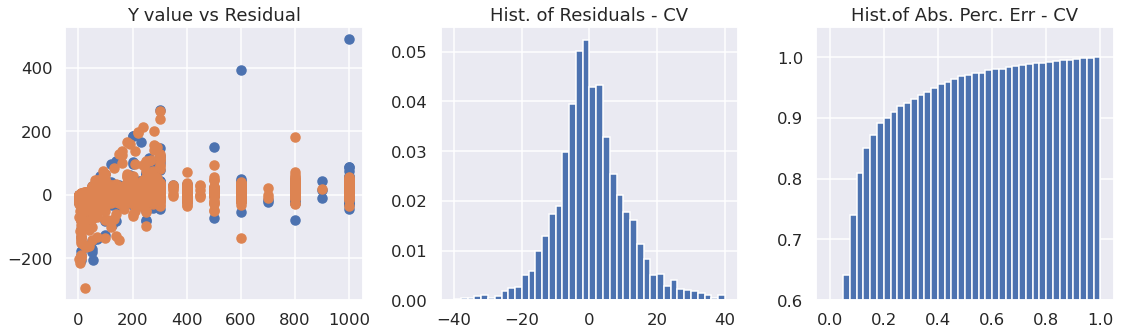

In [290]:
fig, ax = plt.subplots(1,3,figsize=(16,5))

ax[0].scatter(y_cv,y_cv-y_pred_nn_cv, label='Cross Validation')
ax[0].scatter(y,y-y_pred_nn, label='Training')
ax[0].set_title('Y value vs Residual')

ax[1].hist(y_cv-y_pred_nn_cv, density=True, range=(-40,40), bins=40)
ax[1].set_title('Hist. of Residuals - CV')

ax[2].hist(error_per_nn,range=(0,1),cumulative=True, density=True, bins=40)
ax[2].set_ylim(.6)
ax[2].set_title('Hist.of Abs. Perc. Err - CV')

plt.tight_layout()

### Feature Importance
Permutation importance only for NN

In [163]:
r_nn = permutation_importance(reg_mlp, X_cv, y_cv,
                           n_repeats=10, random_state=0)

In [164]:
importances_nn = r_nn.importances_mean

In [165]:
importances_nn = importances_nn.reshape(1,len(importances_nn))

In [221]:
idx_nn = np.argsort(importances_nn)[0]

#### Plot feature importance

Text(0.5, 1.0, 'MLP NN - Permutation Feat. Import.')

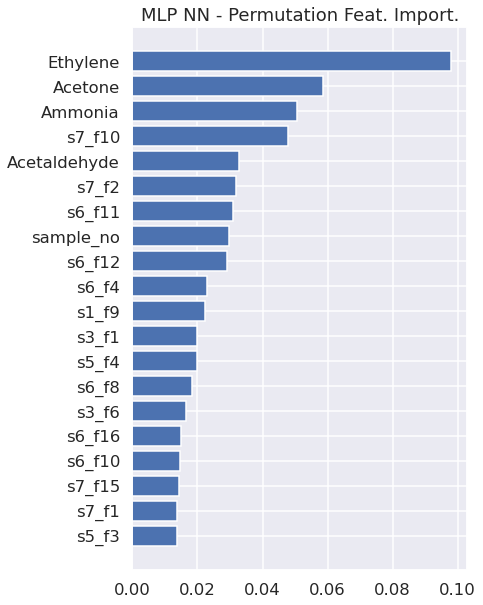

In [229]:
pos = np.arange(feature_labels.shape[1])
fig, ax = plt.subplots(figsize=(6,10))
top_features = 20

ax.barh(pos[-top_features:], importances_nn[0,idx_nn[-top_features:]])
ax.set_yticks(pos[-top_features:])
ax.set_yticklabels(feature_labels[0,idx_nn[-top_features:]])

ax.set_title('MLP NN - Permutation Feat. Import.')

# Comparison
-All models are pretty prone to cause pretty large residuals in a small percentage
-Distribution is very heavy tailed
-All models show sample_no (proxy for time of the sample) as an import variable

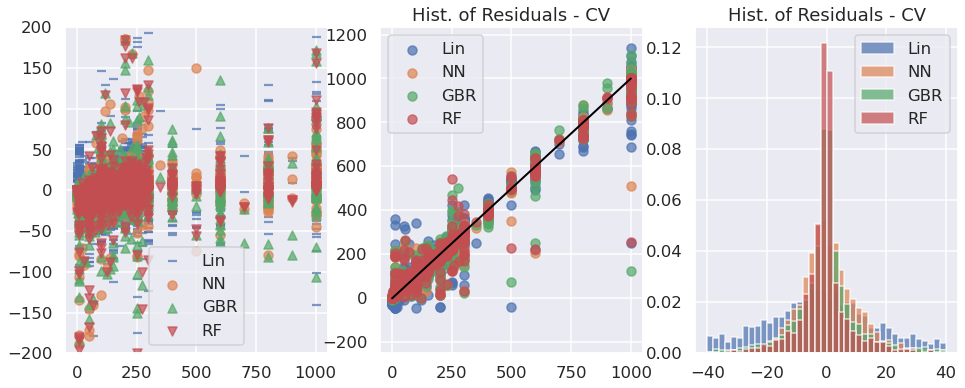

In [447]:
fig, ax = plt.subplots(1,3,figsize=(16,6))

ax[0].scatter(y_cv,y_cv-y_pred_lin_cv, label='Lin', marker='_', alpha=.7)
ax[0].scatter(y_cv,y_cv-y_pred_nn_cv, label='NN', marker='o', alpha=.7)
ax[0].scatter(y_cv,y_cv-y_pred_gbr_cv, label='GBR', marker='^', alpha=.7)
ax[0].scatter(y_cv,y_cv-y_pred_rf_cv, label='RF', marker='v', alpha=.7)
ax[0].legend()

ax[0].set_ylim(-200,200)


ax[1].scatter(y_cv,y_pred_lin_cv, label='Lin', alpha=.7)
ax[1].scatter(y_cv,y_pred_nn_cv, label='NN',  alpha=.7)
ax[1].scatter(y_cv,y_pred_gbr_cv, label='GBR', alpha=.7)
ax[1].scatter(y_cv,y_pred_rf_cv, label='RF', alpha=.7)
ax[1].set_title('Hist. of Residuals - CV')
ax[1].plot([0,1000],[0,1000],c='black', linewidth=2)
ax[1].set_ylim(-250,)
ax[1].legend()

ax[2].hist(y_cv-y_pred_lin_cv, label='Lin', density=True, range=(-40,40), bins=40, alpha=.7)
ax[2].hist(y_cv-y_pred_nn_cv, label='NN', density=True, range=(-40,40), bins=40, alpha=.7)
ax[2].hist(y_cv-y_pred_gbr_cv, label='GBR', density=True, range=(-40,40), bins=40, alpha=.7)
ax[2].hist(y_cv-y_pred_rf_cv, label='RF', density=True, range=(-40,40), bins=40, alpha=.7)
ax[2].set_title('Hist. of Residuals - CV')
ax[2].legend()

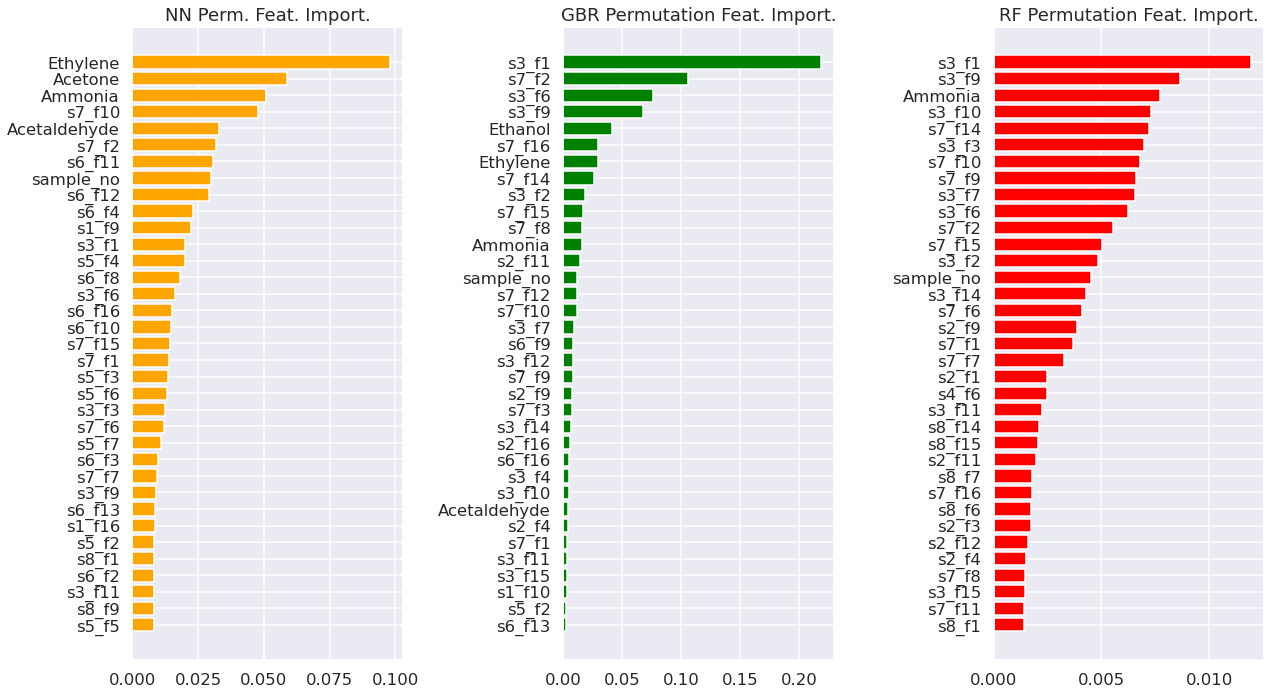

In [445]:
pos = np.arange(feature_labels.shape[1])
fig, ax = plt.subplots(1,3,figsize=(18,10))
top_features = 35

ax[0].barh(pos[-top_features:], importances_nn[0,idx_nn[-top_features:]], color='orange')
ax[0].set_yticks(pos[-top_features:])
ax[0].set_yticklabels(feature_labels[0,idx_nn[-top_features:]])
ax[0].set_title('NN Perm. Feat. Import.')

ax[1].barh(pos[-top_features:], perm_import_gbr[perm_idx_gbr[-top_features:]], color='green')
ax[1].set_yticks(pos[-top_features:])
ax[1].set_yticklabels(feature_labels[0,perm_idx_gbr[-top_features:]])
ax[1].set_title('GBR Permutation Feat. Import.')


ax[2].barh(pos[-top_features:],perm_import_rf[perm_idx_rf[-top_features:]], color='red')
ax[2].set_yticks(pos[-top_features:])
ax[2].set_yticklabels(feature_labels[0,perm_idx_rf[-top_features:]])
ax[2].set_title('RF Permutation Feat. Import.')

plt.tight_layout()

In [355]:
r2_score(y_cv,y_pred_ens_cv)

0.9738501137965657

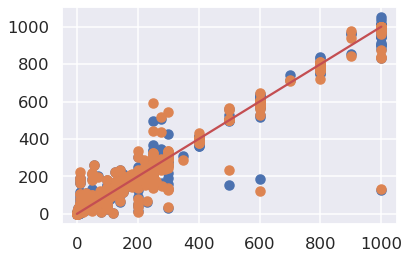

In [366]:
plt.scatter(y_cv,y_pred_ens_cv)
plt.scatter(y_cv,y_pred_rf_cv)
plt.plot([0,1000],[0,1000],c='r')

### Ensemble performance
Ensemble model has the fewest data points with more than 10% error

In [357]:
len(y_pred_nn_cv[abs(y_cv-y_pred_nn_cv)/y_cv > .1])/len(y_cv)

0.28720345075485265

In [363]:
len(y_pred_nn_cv[abs(y_cv-y_pred_nn_cv)/y_cv < .55])/len(y_cv)

0.9360172537742631

In [359]:
len(y_pred_gbr_cv[abs(y_cv-y_pred_gbr_cv)/y_cv > .1])/len(y_cv)

0.2670740474478792

In [360]:
len(y_pred_gbr_cv[abs(y_cv-y_pred_gbr_cv)/y_cv < .55])/len(y_cv)

0.9496764917325665

In [364]:
len(y_pred_rf_cv[abs(y_cv-y_pred_rf_cv)/y_cv > .1])/len(y_cv)

0.16714593817397555

In [365]:
len(y_pred_rf_cv[abs(y_cv-y_pred_rf_cv)/y_cv < .55])/len(y_cv)

0.9547088425593099

In [361]:
len(y_pred_ens_cv[abs(y_cv-y_pred_ens_cv)/y_cv > .1])/len(y_cv)

0.19482386772106397

In [362]:
len(y_pred_ens_cv[abs(y_cv-y_pred_ens_cv)/y_cv < .55])/len(y_cv)

0.9529115744069016

In [ ]:
kwargs = {'cumulative': True}
sns.distplot((y_cv-y_pred_gbr_cv)/y_cv,bins=300)
sns.distplot((y_cv-y_pred_nn_cv)/y_cv,bins=300)
sns.distplot((y_cv-y_pred_ens_cv)/y_cv,bins=300)
#plt.xscale('log')
plt.xlim(-1,1)
#plt.ylim(.9,1)

In [276]:
estimators = [
    ('gbr',GradientBoostingRegressor(loss='lad',max_depth=50,n_estimators=125,learning_rate=.15)),
    ('mlp', MLPRegressor(max_iter=1000,hidden_layer_sizes=tuple(n*[136]),alpha=0.00001))
]

In [231]:
from sklearn.ensemble import StackingRegressor

In [277]:
reg = StackingRegressor(estimators=estimators, final_estimator=GradientBoostingRegressor(loss='lad'))

In [278]:
reg.fit(X,y)

StackingRegressor(estimators=[('gbr',
                               GradientBoostingRegressor(learning_rate=0.15,
                                                         loss='lad',
                                                         max_depth=50,
                                                         n_estimators=125)),
                              ('mlp',
                               MLPRegressor(alpha=1e-05,
                                            hidden_layer_sizes=(136, 136, 136,
                                                                136, 136, 136),
                                            max_iter=1000))],
                  final_estimator=GradientBoostingRegressor(loss='lad'))

In [279]:
y_pred_stack_cv = reg.predict(X_cv)

In [283]:
len(y_pred_stack_cv[abs(y_cv-y_pred_stack_cv)/y_cv < .55])/len(y_cv)

0.9507548526240115

In [281]:
y_pred_stack_cv

array([104.99755507, 103.77867939,  38.95413651, ...,  57.2052999 ,
       204.39685015,  20.00376661])